In [1]:
import math

import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdastr, lambdify, implemented_function
import matplotlib.pyplot as plt

sp.init_printing()

This notebook tries to asses what would
the pseudorandom sequence produced by `microrng.c/.h`
module would look like if CPU clock and
watchdog oscillator both had zero drift
and random numbers were always used the moment
the generator has accumulated enough randomness.

As is easy to see from lag plots for raw 
samples, random numbers generator 
generator output and numpy's random number generator,
microrng would produce something very far from
random in conditions described above.

In reality the situation will be somewhat better
because watchdog oscillator drift and the fact
that random numbers are not used as fast as 
they are produced so some timer0 samples are skipped.

In [2]:
F_CPU         = sp.symbols('F_{CPU}')
TIMER_DIVIDER = sp.symbols('D_{CPU}')
TIMER_MAX_CTR = sp.symbols('N_{maxtimer0}')
F_WD          = sp.symbols('F_{watchdog}')
WD_DIVIDER    = sp.symbols('D_{watchdog}')
t             = sp.symbols('t')
WD_idx        = sp.symbols('i_{watchdog}')
idx           = sp.symbols('i')

In [3]:
TIMER_MAX_CTR

In [4]:
data = {
    F_CPU:16500000,
    TIMER_DIVIDER:1024,
    TIMER_MAX_CTR:81,
    F_WD:128000,
    WD_DIVIDER:2048}

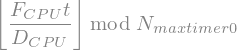

In [5]:
timer0_value_expr = sp.Mod(sp.floor(t * F_CPU / TIMER_DIVIDER), TIMER_MAX_CTR)
timer0_value_expr

In [6]:
time_at_wd_count_expr = WD_idx/(1/(F_WD/WD_DIVIDER))
time_at_wd_count_expr

In [7]:
timer0_value_at_wd_idx_expr = timer0_value_expr.subs({t: time_at_wd_count_expr})
timer0_value_at_wd_idx_expr

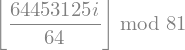

In [8]:
timer0_value_at_wd_idx_expr_num = timer0_value_at_wd_idx_expr.subs(data).subs({WD_idx: idx})
timer0_value_at_wd_idx_expr_num

In [9]:
lambdastr(idx, timer0_value_at_wd_idx_expr_num, )


'lambda i: ((math.floor((64453125/64)*i)) % 81)'

In [10]:
def timer0_value_at_wd_idx(i):
    return timer0_value_at_wd_idx_expr_num.subs({idx:i})

In [11]:
l1 = [timer0_value_at_wd_idx(i) for i in range(0,10000)]

In [12]:
l2 = [((math.floor((64453125/64)*i)) % 81) for i in range(0,10000)]

In [13]:
np.all(np.array(l1)==np.array(l2))

True

In [14]:
def timer0_value_at_wd_idx(i):
    return ((math.floor((64453125/64)*i)) % 81)

In [15]:
random_samples = \
    np.array([
        timer0_value_at_wd_idx(i) 
        for i in range(0,8*100000)], 
    dtype=np.uint8)

In [16]:
fig, ax = plt.subplots()
ax.scatter(random_samples[:-1], random_samples[1:])

(array([10186.,  9722.,  9722., 10185.,     0.,  9723.,  9722., 10185.,
         9723.,     0.,  9722., 10185.,  9722.,  9723.,     0., 10185.,
         9722.,  9723., 10185.,     0.,  9722.,  9722., 10186.,  9722.,
            0.,  9722., 10186.,  9722.,  9722.,     0., 10185.,  9723.,
         9722., 10185.,     0.,  9723.,  9722., 10185.,  9722.,     0.,
         9723., 10184.,  9722.,  9723.,     0., 10185.,  9722.,  9722.,
        10186.,     0.,  9721.,  9722., 10186.,  9723.,     0.,  9721.,
        10185.,  9723.,  9721.,     0., 10185.,  9723.,  9723., 10184.,
            0.,  9722.,  9723., 10185.,  9721.,     0.,  9723., 10186.,
         9721.,  9722.,     0., 10186.,  9722.,  9721., 10186.,     0.,
         9723.,  9722., 10184.,  9723.,     0.,  9722., 10184.,  9723.,
         9723.,     0., 10185.,  9721.,  9723., 10185.,     0.,  9722.,
         9722., 10186.,  9722.,  9722.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 

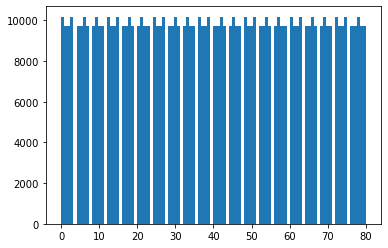

In [17]:
fig, ax = plt.subplots()

ax.hist(random_samples, bins=100)

In [18]:
def rotl_1(x) -> np.uint8:
    return np.bitwise_or(np.left_shift(x, 1), np.right_shift(x, 7))    

In [19]:
res = np.zeros(100000, dtype=np.uint8)
for i in range(0, 100000):
    if i>0:
        res[i] = res[i-1]
    for j in range(8):
        res[i] = np.bitwise_xor(rotl_1(res[i]), random_samples[i*8+j])    
        

In [20]:
fig, ax = plt.subplots()
ax.scatter(res[1:], res[:-1], 1)

(array([[  0.,   0.,   0., ..., 231.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0., 232.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0., 231., 231., ...,   0.,   0.,   0.],
        [  0., 232.,   0., ...,   0.,   0.,   0.]]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 17

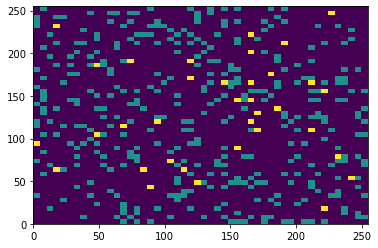

In [21]:
fig, ax = plt.subplots()
ax.hist2d(res[1:], res[:-1], 50)

In [22]:
res_rnd = np.random.randint(0,high=256,size=100000, dtype=np.uint8)

In [23]:
fig, ax = plt.subplots()
ax.scatter(res_rnd[1:], res_rnd[:-1], 1)

In [24]:
fig, ax = plt.subplots()
ax.hist2d(res_rnd[1:], res_rnd[:-1], 50)

(array([[60., 50., 44., ..., 38., 48., 47.],
        [58., 38., 37., ..., 33., 39., 44.],
        [49., 29., 31., ..., 44., 28., 55.],
        ...,
        [46., 55., 34., ..., 50., 38., 54.],
        [44., 34., 37., ..., 35., 25., 34.],
        [48., 49., 56., ..., 45., 37., 54.]]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 19